In [250]:
# pip install geopandas
# pip install matplotlib

In [251]:
# get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [252]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from shapely.affinity import scale

In [253]:
answers = pd.read_csv("answers_df.csv")
guessed = pd.read_csv("guesses_df.csv")
df = answers.merge(guessed, on=["gameId", "roundNumber"], suffixes=("_answer", "_guess"))
games = pd.read_csv("games_df.csv")
df = df.merge(games, left_on="gameId", right_on="game_id", suffixes=("", "_game"))
df.head()

,gameId,roundNumber,lat_answer,lng_answer,country_code_answer,lat_guess,lng_guess,distance,time,score,wasCorrect,playerName,code,playerId,payload,timestamp,lobby,countryGuess,coordinateGuess,battleRoyaleGameState,battleRoyalePlayer,duel,bullseye,player,country_code_guess,game_id,forbidMoving,forbidZooming,forbidRotating,roundCount,mapSlug,roundTime,isSinglePlayer,scoringType,context,date
0,d30d3d04-d8d1-44cb-ab9e-294433578265,1,-78.065498,164.144104,AQ,-77.892021,164.165270,1.929601e+04,13,4936,False,test,LiveChallengeLeaderboardUpdate,NaN,NaN,2024-10-11T13:38:26.3355702Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,AQ,d30d3d04-d8d1-44cb-ab9e-294433578265,True,False,False,5,world,20,False,Unknown,NaN,2024-10-11T13:39:41.699Z
1,d30d3d04-d8d1-44cb-ab9e-294433578265,1,-78.065498,164.144104,AQ,-74.804460,-61.901268,2.776140e+06,8,778,False,Demaga Chill,LiveChallengeLeaderboardUpdate,NaN,NaN,2024-10-11T13:38:26.3355702Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Demaga Chill,AR,d30d3d04-d8d1-44cb-ab9e-294433578265,True,False,False,5,world,20,False,Unknown,NaN,2024-10-11T13:39:41.699Z
2,d30d3d04-d8d1-44cb-ab9e-294433578265,2,13.854082,100.843712,TH,23.657437,80.609720,2.388970e+06,5,1008,False,test,LiveChallengeLeaderboardUpdate,NaN,NaN,2024-10-11T13:38:46.1759818Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,IN,d30d3d04-d8d1-44cb-ab9e-294433578265,True,False,False,5,world,20,False,Unknown,NaN,2024-10-11T13:39:41.699Z
3,d30d3d04-d8d1-44cb-ab9e-294433578265,2,13.854082,100.843712,TH,22.149432,76.034668,2.776280e+06,9,777,False,Demaga Chill,LiveChallengeLeaderboardUpdate,NaN,NaN,2024-10-11T13:38:46.1759818Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Demaga Chill,IN,d30d3d04-d8d1-44cb-ab9e-294433578265,True,False,False,5,world,20,False,Unknown,NaN,2024-10-11T13:39:41.699Z
4,d30d3d04-d8d1-44cb-ab9e-294433578265,3,13.557908,144.854996,GU,12.122552,-84.812403,1.384006e+07,10,0,False,test,LiveChallengeLeaderboardUpdate,NaN,NaN,2024-10-11T13:39:06.4370248Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,NI,d30d3d04-d8d1-44cb-ab9e-294433578265,True,False,False,5,world,20,False,Unknown,NaN,2024-10-11T13:39:41.699Z


In [254]:
df = df.groupby("playerName").filter(lambda x: len(x) > 100)
df = df[(df["mapSlug"] == "world") & (df["forbidMoving"] == True) & (df["roundCount"] == 5) & (df["roundTime"].isin([30, 40]))]
df["guessed"] = df.apply(lambda row: row["country_code_answer"] == row["country_code_guess"], axis=1)
df = df[["gameId", "roundNumber", "country_code_answer", "guessed"]]
df = df.rename(columns={"country_code_answer": "country"})
df.sample(5)

,gameId,roundNumber,country,guessed
6827,4cc7505e-35f2-43f7-a40a-5962fe784f65,1,GB,True
3360,cc4e62e7-bae7-48b9-81e1-ff6504983025,4,PT,False
1165,f56ec55e-118a-4130-81aa-c20ff485d42e,4,JO,False
3985,c40e6798-271f-4e4e-80bc-2e9af74d002d,5,TW,True
5171,c2bacd6c-5f21-4c66-92a8-9c7821185c6e,5,HU,False


In [255]:
stats = df[["country", "guessed"]].groupby(by=["country", "guessed"]).size().unstack(
    fill_value=0
)
stats.columns = ['False', 'True']
stats['Total'] = stats['False'] + stats['True']
max_value = stats["Total"].max()
stats["resize_factor"] = stats["Total"] / max_value
stats["guess_ratio"] = stats["True"] / stats["Total"]
stats = stats.reset_index()
stats

,country,False,True,Total,resize_factor,guess_ratio
0,AD,5,2,7,0.044304,0.285714
1,AE,15,10,25,0.158228,0.400000
2,AL,31,6,37,0.234177,0.162162
3,AQ,19,7,26,0.164557,0.269231
4,AR,100,22,122,0.772152,0.180328
...,...,...,...,...,...,...
106,UG,9,3,12,0.075949,0.250000
107,US,31,102,133,0.841772,0.766917
108,UY,53,10,63,0.398734,0.158730
109,VI,12,0,12,0.075949,0.000000


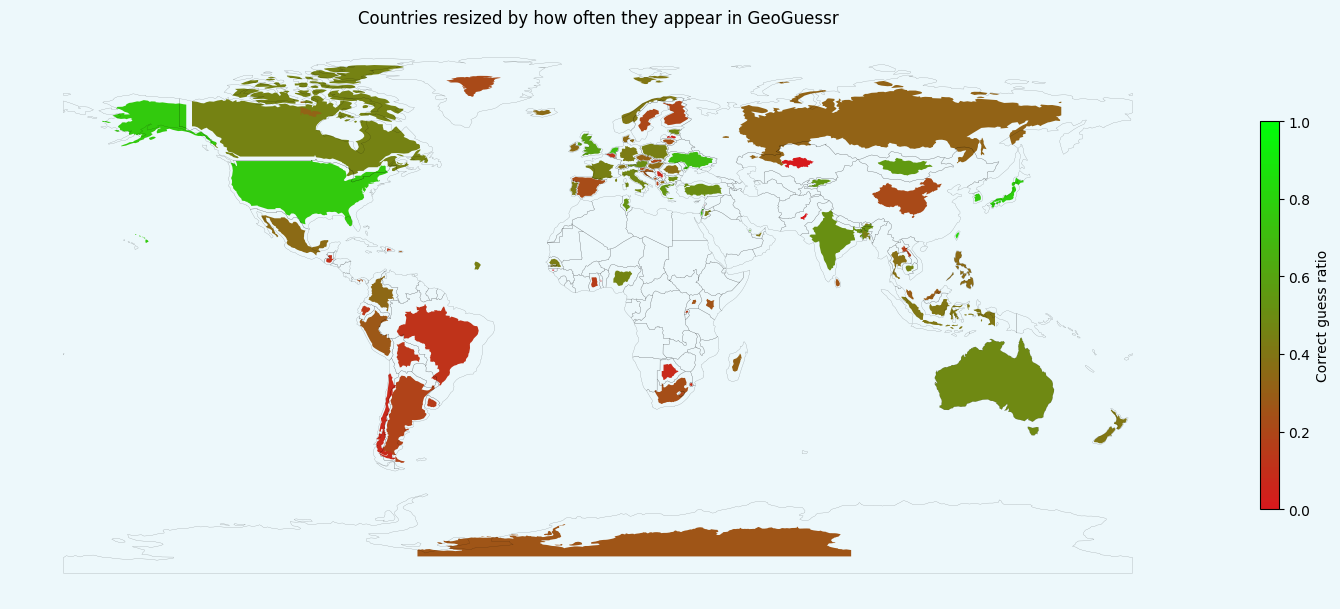

In [273]:
world = gpd.read_file("ne_110m_admin_0_countries.zip")
original_world = world.copy()
# continents = world.dissolve(by="CONTINENT")
world = world.merge(stats, how="left", left_on="ISO_A2_EH", right_on="country")
world["guess_ratio"] = world["guess_ratio"].fillna(1)


def resize_geometry(row):
    geom = row["geometry"]
    resize_factor = row["resize_factor"]
    if not isinstance(resize_factor, float) or pd.isna(resize_factor):
        resize_factor = 0
    centroid = geom.centroid
    scaled = scale(
        geom,
        xfact=np.sqrt(resize_factor),
        yfact=np.sqrt(resize_factor),
        origin=centroid,
    )
    return scaled


world["geometry"] = world.apply(resize_geometry, axis=1)

fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
fig.set_facecolor("#edf8fb")

colors = ["#d7191c", "#00FF09"]  # red to green
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

original_world.boundary.plot(ax=ax1, alpha=0.5, color='black', linewidth=0.15)
world.plot(
    ax=ax1,
    cmap=cmap,
    column="guess_ratio",
    legend=True,
    legend_kwds={"label": "Correct guess ratio", "shrink": 0.4},
)
ax1.set_title("Countries resized by how often they appear in GeoGuessr")
ax1.axis("off")

# continents.boundary.plot(
#     ax=ax1,
#     color='#2F4F4F',  # Dark slate gray
#     linewidth=0.5,
#     linestyle='--'
# )

plt.tight_layout()
plt.show()